Primeiro o data set será divido utilizando o método hold-out e depois os modelos serão execultados. Depois os modelos serão treinados porém utilzando o k-fold para a divisão do dataset.

In [37]:
# Bibliotecas de manipualção e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler

# Classes dos modelo
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [15]:
df_hepatite = pd.read_csv('HCV-Egy-Data.csv')

In [2]:
# dataset sem outliers
df_hepatite = pd.read_csv('HCV-Egy-Data-no-outlier.csv')

A remoção de outliers mostrou-se eficiente na performace do modelo aumentando em serca de 1% a acurácia.

In [80]:
# dataset sem instâncias com valores de rna 5
df_hepatite = pd.read_csv('HCV-Egy-Data-no-rna5.csv')

A remoção das instâncias não se mostrou eficiente para performace do modelo, por isso não será utilizada.

In [82]:
df_hepatite.head()

,Unnamed: 0,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,FGba,Jaundice,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,BhG,Baselinehistological staging
0,1,46,1,29,1,2,2,1,2,2,...,57,123,44,40620,538635,637056,336804,31085,4,2
1,3,49,2,33,1,2,1,2,1,2,...,48,77,33,1041941,449939,585688,744463,582301,10,3
2,5,58,2,22,2,2,2,1,2,2,...,73,114,29,1157452,1086852,5,5,5,4,4
3,6,42,2,26,1,1,2,2,2,2,...,84,80,28,325694,1034008,275095,214566,635157,12,4
4,7,48,2,30,1,1,2,2,1,1,...,96,53,39,641129,72050,787295,370605,506296,12,3


### Seperação da váriável target do dataset

In [18]:
X = df_hepatite.drop(['BhG', 'Baselinehistological staging'], axis=1)
y = df_hepatite['Baselinehistological staging']

### Normalização dos dados

Com a normalização dos dados o modelo melhorou de predição almentou em um valor de 6% na sua acurácia.

In [20]:
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X)

In [40]:
#função que retorna um dicionário com os valores dos resultados
def model_results(model, X_train, y_train, X_test, y_test):
    #listas para salvar as métricas dos resultados
    accuracies_list = []
    f1_score_list = []
    auc_list = []
    confusion_matrix_list = []
    
    #dicionário com todas listas
    results_dict = {
        'accuracy': accuracies_list,
        'f1': f1_score_list,
        'auc': auc_list,
        'cm': confusion_matrix_list
    }
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #medindo e armazenando acurácia, f1-score e auc-score no dicionário
    acuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    AUC = roc_auc_score(y_test, model.predict_proba(X_test), average='macro', multi_class='ovo')
    CM = confusion_matrix(y_test, y_pred)

    results_dict['accuracy'].append(acuracy)
    results_dict['f1'].append(f1)
    results_dict['auc'].append(AUC)
    results_dict['cm'].append(CM)
    print(f"CM: \n{CM} \n")

    return results_dict

In [ ]:
def kNN_grid_search(X_train, y_train):
    #lista com números impares para o número de vizinhos do knn
    k_range = [impar for impar in range(1,32) if (impar%2)!=0]
    #listas com formas de considerar a ditância do vizinho
    weights = ['uniform', 'distance']
    #lista com formas de calcular as distâncias
    dist = ['euclidian','manhattan','chebyshev']
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'n_neighbors': k_range,
        'weights': weights,
        'metric': dist
    }
    # defining parameter range
    grid = GridSearchCV(knn(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    k = grid.best_params_['n_neighbors']
    w = grid.best_params_['weights']
    m = grid.best_params_['metric']
    print(f"k:{k}, w:{w}, m:{m}\n")

    return (k,w,m)

## 10-Fold

Com esse método são criados 10 datasets de treino e 10 datasets de test com uma divisão de 90% para treino e 10% para teste em cada divisão.

In [35]:
#função que roda os modelos em cada uma das divisões do 10-fold
#e imprime a média e o desvio padrão dos resultados

def evaluate_model_with_kfold(kf):
    results_dict = {}
    
    for train, test in kf.split(X, y):
        X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]

        #kNN
        k,w,m = kNN_grid_search(X_train, y_train)
        model = knn(n_neighbors=19)
        results_dict['knn'] = model_results(model, X_train, y_train, X_test, y_test)

        #DT
        model = DecisionTreeClassifier(random_state=199)
        results_dict['DT'] = model_results(model, X_train, y_train, X_test, y_test)

        #MLP 
        model = MLPClassifier(random_state=199)
        results_dict['MLP'] = model_results(model, X_train, y_train, X_test, y_test)

        #GNB 
        model = GaussianNB()
        results_dict['GNB'] = model_results(model, X_train, y_train, X_test, y_test)

        #BNB 
        model = BernoulliNB()
        results_dict['GNB'] = model_results(model, X_train, y_train, X_test, y_test)

        #SVM
        model = SVC(C=1, kernel='rbf', probablity=True)
        results_dict['SVM'] = model_results(model, X_train, y_train, X_test, y_test)

    # a cada interação calcula a média e o desvio padrão da 
    # acurácia, f1-score, auc-scor e matriz de confusão de cada modelo
    for model_key in results_dict.keys():
        accuracies = np.array(results_dict[model_key]['accuracy'])
        f1 = np.array(results_dict[model_key]['f1'])
        auc = np.array(results_dict[model_key]['auc'])

        print(model_key)
        print("Acurácia média (desvio): %.6f +- (%.6f)" %(accuracies.mean(), accuracies.std()))
        print("F1-score média (desvio): %.6f +- (%.6f)" %(f1.mean(), f1.std()))
        print("AUC média (desvio): %.6f +- (%.6f)\n" %(auc.mean(), auc.std()))
        print(f"Matriz de Confusão:  \n{np.mean(conf_matrix,axis=0)}\n")

## KNN

In [86]:
#lista com números impares para o k do knn
k_range = [impar for impar in range(1,32) if (impar%2)!=0]
param_grid = dict(n_neighbors=k_range)

In [87]:
# defining parameter range
KNN = KNeighborsClassifier()
grid = GridSearchCV(KNN, param_grid, cv=10, scoring='accuracy')
  
# fitting the model for grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31]},
             scoring='accuracy')

In [88]:
print(grid.best_params_)

{'n_neighbors': 19}


In [89]:
accuracy = grid.best_score_*100
accuracy

30.289855072463766

In [54]:
# vamos criar um classificador kNN com k=11
model = knn(n_neighbors=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# e ver a sua performance no dataset de teste
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.21      0.21      0.21        84
           2       0.24      0.25      0.24        83
           3       0.35      0.33      0.34        89
           4       0.34      0.34      0.34        90

    accuracy                           0.29       346
   macro avg       0.29      0.28      0.29       346
weighted avg       0.29      0.29      0.29       346



In [55]:
print(accuracy_score(y_test, y_pred))

0.2861271676300578


In [56]:
print(f1_score(y_test, y_pred, average='macro'))

0.28504862095278455


In [57]:
print(roc_auc_score(y_test, model.predict_proba(X_test), average='macro', multi_class='ovo'))

0.5229308172586906


c:\users\tasso\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


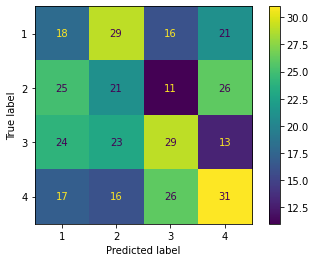

In [58]:
plot_confusion_matrix(model,X_test,y_test)